But : compute the correlation coefficient of the lagged S_Gr integral over the whole water column time series.

In [2]:
## standart libraries

import os,sys
import numpy as np

# xarray
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.feature as cfeature
# plot
import regress3d as reg
import cmocean as ccm

In [3]:
from dask.distributed import Client
c = Client()
c

/linkhome/rech/genlop01/uor98hu/.local/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35743 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35743/status,
Dashboard: http://127.0.0.1:35743/status,Workers: 5
Total threads: 10,Total memory: 20.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43473,Workers: 5
Dashboard: http://127.0.0.1:35743/status,Total threads: 10
Started: Just now,Total memory: 20.00 GiB
Comm: tcp://127.0.0.1:43977,Total threads: 2
Dashboard: http://127.0.0.1:36419/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:41153,


### prepare the time series to which I am going to compare the 3D matrix : t = 39 (years)

In [5]:
maskBG = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/TRANSPORT_WP1/polymask2.nc').polymask.squeeze() 

path = "/gpfsscratch/rech/cli/uor98hu/Gr_contribution/integral_wholecolumn"
chunk_size = {"time_counter":1} # {"x":500,"y":500} "x":360,"y":500
S_GR = xr.open_mfdataset(path+"/eORCA025.L75-IMHOTEP.G_y*mall_1m_GrSalinitywholeColumn.nc", chunks=chunk_size).S_GR_integral
clim = S_GR.groupby('time_counter.month').mean("time_counter")
deseasonned = S_GR.groupby('time_counter.month') - clim

S_GR_bis = deseasonned.groupby("time_counter.year").mean('time_counter')
S_Gr_boxBG = S_GR_bis.where(maskBG)  #combine='nested', concat_dim="time_counter"

ts_GAI_AI_boxBG = S_Gr_boxBG.mean(('x','y'))

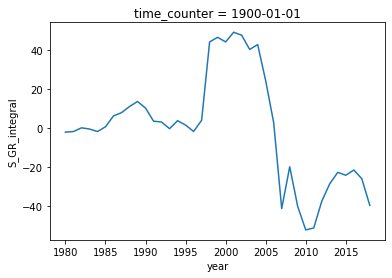

In [6]:
ts_GAI_AI_boxBG.plot()

### définition de la région d'analyse

In [7]:
S_GR_bis

<xarray.DataArray 'S_GR_integral' (year: 39, y: 1207, x: 1442)>
dask.array<stack, shape=(39, 1207, 1442), dtype=float32, chunksize=(1, 1207, 1442), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1980 1981 1982 1983 1984 ... 2014 2015 2016 2017 2018
Dimensions without coordinates: y, x

In [8]:
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
nav_lat = xr.open_dataset(diri+'mesh_hgr.nc')['nav_lat'].squeeze()#.where(nav_lat>=60, drop=True)

S_GR_cropped = S_GR_bis.where(nav_lat>=60, drop=True).load()


# compute the correlation

In [9]:
r_matrix = np.zeros((7,232,1221))

In [29]:
lag=20
expvar,coeffs,p,r = reg.regress3d(ts_GAI_AI_boxBG.values[lag:],S_GR_cropped.values[:-lag,:,:]) 

# lag = 0
# expvar,coeffs,p,r = reg.regress3d(ts_GAI_AI_boxBG.values,S_GR_cropped.values)

# lag = 5 ans
# expvar,coeffs,p,r = reg.regress3d(ts_GAI_AI_boxBG.values[lag:],S_GR_cropped.values[:-lag,:,:]) 

# lag = 10 ans
# expvar,coeffs,p,r_10 = reg.regress3d(ts_GAI_AI_boxBG.values[10:],S_GR_cropped.values[:-10,:,:]) 

# 
# lag = 15
# expvar,coeffs,p,r_15 = reg.regress3d(ts_GAI_AI_boxBG.values[15:],S_GR_cropped.values[:-15,:,:]) 

# lag =20
# expvar,coeffs,p,r_20 = reg.regress3d(ts_GAI_AI_boxBG.values[20:],S_GR_cropped.values[:-20,:,:]) 


# lag = 25
# expvar,coeffs,p,r_25 = reg.regress3d(ts_GAI_AI_boxBG.values[25:],S_GR_cropped.values[:-25,:,:]) 

/gpfsdswork/projects/rech/cli/uor98hu/pythonfiles/lagged_correlation/regress3d.py:53: RuntimeWarning: invalid value encountered in true_divide
  expvar=(1-(SSE/SSY))*100.0
/gpfsdswork/projects/rech/cli/uor98hu/pythonfiles/lagged_correlation/regress3d.py:72: RuntimeWarning: invalid value encountered in true_divide
  t = coeffs[1,:] / serr
/gpfsdswork/projects/rech/cli/uor98hu/pythonfiles/lagged_correlation/regress3d.py:80: RuntimeWarning: invalid value encountered in sqrt
  r=0.1*np.sqrt(expvar)


In [30]:
r2plot = xr.DataArray(r,dims=["y", "x"])
r_matrix[4,:,:] = r
r_matrix2plot = xr.DataArray(r_matrix,dims=["lag","y", "x"], coords=dict(lag=np.arange(0,35,5)))


## plot nicely

In [13]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [14]:
# read grid files

tmask = xr.open_dataset(diri+'mesh_hgr.nc')['tmask'][0,0,:,:].where(nav_lat>=60, drop=True) # grille lat/lon
nav_lon = xr.open_dataset(diri+'mesh_hgr.nc')['nav_lon'].squeeze().where(nav_lat>=60, drop=True)
mbathy = xr.open_dataset(diri+'eORCA025.L75_domain_cfg_closed_seas_greenland.nc')['bathy_meter'].isel(t=0).where(nav_lat>=60, drop=True) # grille lat/lon
nav_lat = nav_lat.where(nav_lat>=60, drop=True)

# land mask from model
m2plt      = tmask.where(tmask==0)

# default gridlines parameters
gridl=False
incrgridlon=30
incrgridlat=10

# vue N.Atl
# loncentr=330 # before it was zero
# latcentr=70
#vue polaire
loncentr=200 # before it was zero
latcentr=90

sath=2085831

nav_lon2plot = nav_lon.fillna(0)
nav_lat2plot = nav_lat.fillna(0)
# boxlon = [nav_lon[1092,479],nav_lon[1118,460],nav_lon[1134,479],nav_lon[1111,505],nav_lon[1092,479] ]
# boxlat = [nav_lat[1092,479],nav_lat[1118,460],nav_lat[1134,479],nav_lat[1111,505],nav_lat[1092,479] ]

In [15]:
cmap = ccm.cm.balance
my_map1 = truncate_colormap(cmap, 0, 0.4)
my_map2 = truncate_colormap(cmap, 0.6, 1)
colors1 = my_map1(np.linspace(0., 1, 50))
colors2 = my_map2(np.linspace(0., 1, 50))
colors = np.vstack(( colors1, colors2))
mycm = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

In [16]:
lmin = -1.0
incr = 0.1
lmax = lmin*(-1)+0.1
# define the bins and normalize
bounds = np.arange(lmin,lmax,incr)
norm = mcolors.BoundaryNorm(bounds, mycm.N)

In [21]:
r_matrix2plot.sel(lag=lag)

<xarray.DataArray (y: 232, x: 1221)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lag      int64 5
Dimensions without coordinates: y, x

S_GRdeseasonnedCorrelation_map_lag20years.png


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


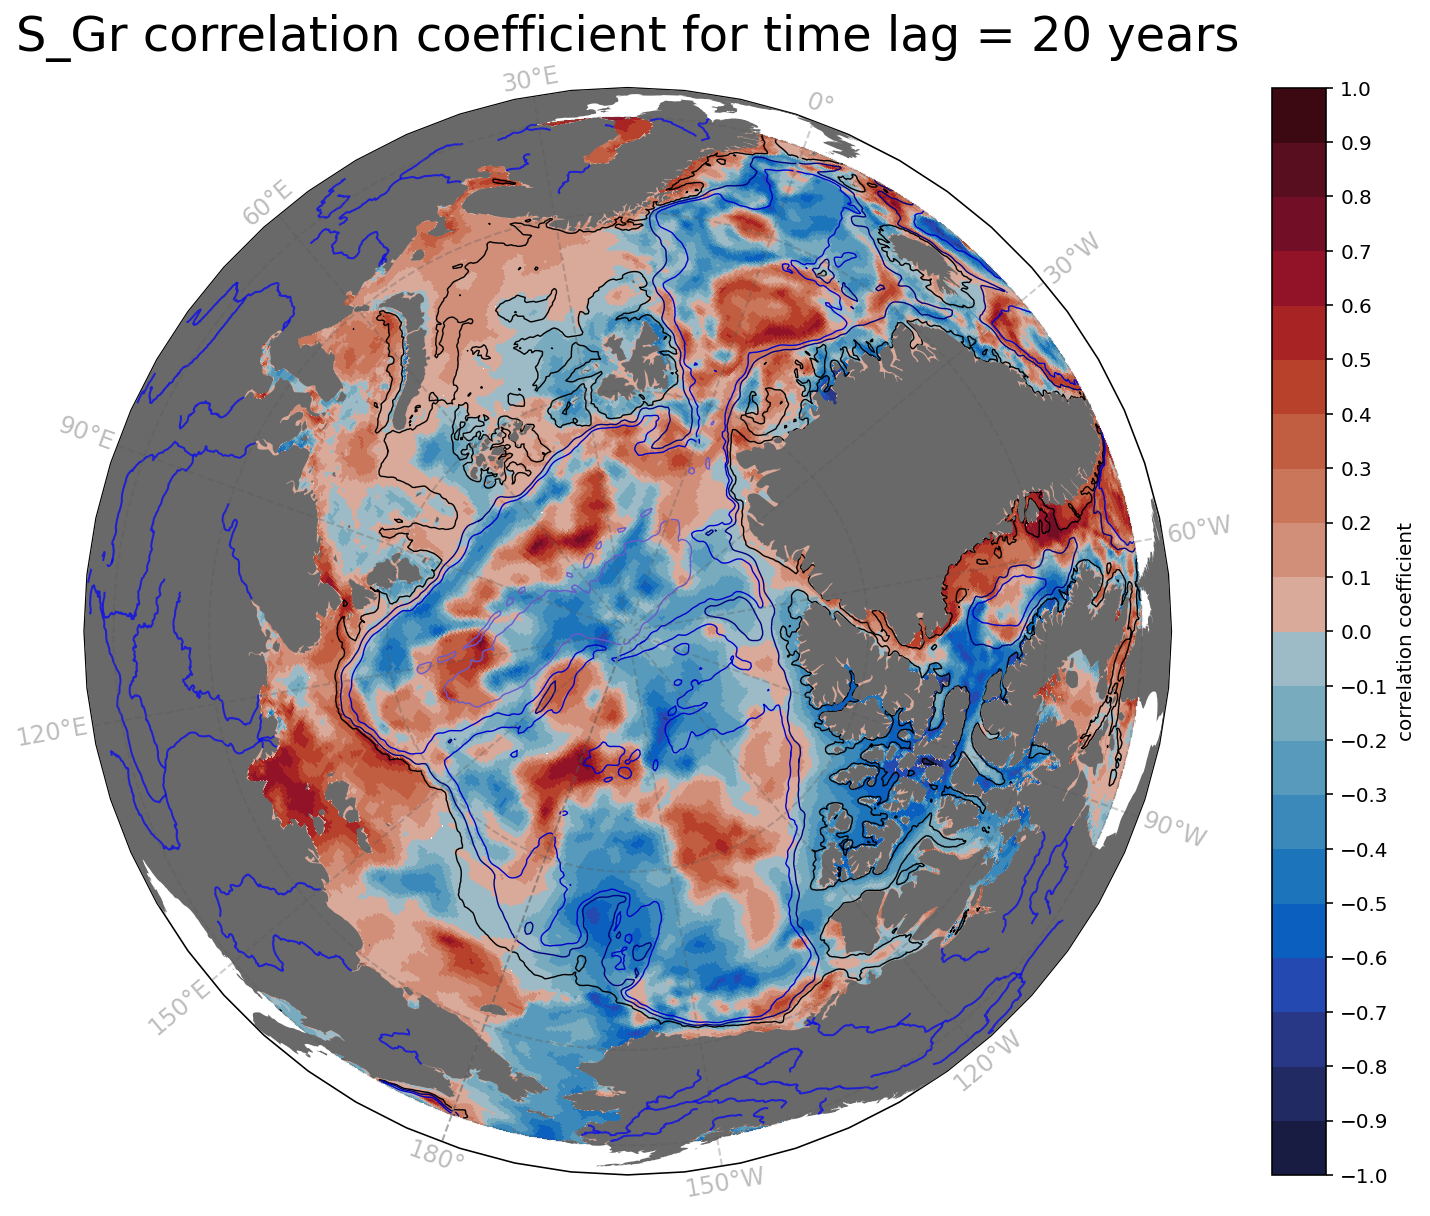

<Figure size 432x288 with 0 Axes>

In [31]:
#========= CREATE FIGURE
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"
    
# RUN to PLOT
data2plot = r_matrix2plot.sel(lag=lag).where(tmask!=0,0).squeeze()
# yr, mm = dates(S_GR_short.isel(time_counter=t))
tlabel= "S_Gr correlation coefficient for time lag = "+str(lag)+" years" #"whole column S_GR integral for "+str(yr)+"-"+f"{mm:02d}" + r" [10$-3$]"
namo  ="S_GRdeseasonnedCorrelation_map_lag"+str(lag)+"years"+".png"
print(namo)
#===========================================
fig = plt.figure(figsize=([18,10]),facecolor='none', dpi=72*2)

trdata  = ccrs.PlateCarree() # Data system proj (if coords are in lat lon, use PlateCarre here)
ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath))

#========= PLOT DATA

# plt.plot(boxlon,boxlat,color='k', transform=trdata)
cs  = plt.pcolormesh(nav_lon2plot, nav_lat2plot, data2plot,shading='flat',cmap = mycm,transform=trdata, norm=norm)
fig.colorbar(cs,extend='neither', ticks=bounds,label=r'correlation coefficient')

# cs2  = plt.pcolormesh(nav_lon, nav_lat, m2plt, shading='flat',transform=trdata) 
#========= coastlines and gridlines
rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')
clr2 = ax.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2 = ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl =ax.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
label_style = {'size': 12, 'color': '#BDBDBD', 'weight': 'normal'}
gl.xlabel_style = label_style; gl.ylabel_style = label_style


#============= BATHYMETRY
bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
color_levels= ['k','navy','mediumblue','slateblue']
# west
Ct1 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
# east
Ct2 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)


plt.title(tlabel,fontsize=24)
plt.show()
fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
# plt.close(fig)
plt.clf()